Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# For those who don't have "ECE239AS Group Project" inside "MyDrive"
# (for me, "ECE239AS Group Project" was originally in "Shared with me")
# Right click on "ECE239AS Group Project" > click "Add shortcut to drive" > click "MyDrive"
# (https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)

% cd '/content/drive/MyDrive/ECE239AS Group Project/code'

/content/drive/My Drive/0_file_sharing/ECE239AS Group Project/code


In [3]:
# import libraries
!pip install box2d-py
!pip install roboschool==1.0.48 gym==0.15.4
# !pip install pybullet

import gym
import torch
import torch.nn as nn
import numpy as np
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import os
import time
from datetime import datetime
import torch.nn.functional as F
import numpy as np
import roboschool

import matplotlib.pyplot as plt

     |████████████████████████████████| 450kB 28.2MB/s 
     |████████████████████████████████| 44.9MB 160kB/s 
     |████████████████████████████████| 1.6MB 39.6MB/s 
     |████████████████████████████████| 1.0MB 31.7MB/s 
  Created wheel for gym: filename=gym-0.15.4-cp37-none-any.whl size=1648486 sha256=cc27d15615d9603377297a0580d756a04e5e6c3ee81c7d80bf9a2a8500d34656
  Stored in directory: /root/.cache/pip/wheels/e9/26/9b/8a1a6599a91077a938ac4348cc3d3ac84bfab0dbfddeb4c6e7
Successfully built gym
ERROR: tensorflow-probability 0.12.1 has requirement cloudpickle>=1.3, but you'll have cloudpickle 1.2.2 which is incompatible.
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [4]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class PPO:
	"""
	we dont need the actor critic
	 we just need to supply 2 NN modules, one is the actor one is the critic

	Update:
		we just need to get returns


	MC_function:

	TD_function: Do a little more reading
				what we need for this part
	"""
	def __init__(self,
				actor: nn.Module,
				critic: nn.Module,
				action_dim,
				lrate_actor,
				lrate_critic, 
				gamma, 
				epochs, 
				epsilon,
				has_continuous_action_space,
				device,
				using_TD = False,
				action_std_init=1):

		self.discount_factor = gamma
		self.device = device
		self.clip_factor = epsilon
		self.epochs = epochs
		self.buffer = RolloutBuffer()
		self.action_dim = action_dim
		self.actor = actor.to(device)
		self.critic = critic.to(device)
		self.optimizer = torch.optim.Adam(
			[ 
				{'params': self.actor.parameters(), 'lr': lrate_actor},
				{'params': self.critic.parameters(), 'lr': lrate_critic}
			]
		)
		self.using_TD = using_TD

		self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
		
		self.continuous = has_continuous_action_space

	def select_action(self, state):

		with torch.no_grad():
			state = torch.FloatTensor(state).to(self.device)
			if self.continuous:
				action_mean = self.actor(state)

				cov_mat = torch.diag(self.action_var).unsqueeze(dim=0).to(self.device).type('torch.FloatTensor')
				dist = MultivariateNormal(action_mean, cov_mat)
			else:
				action_probs = self.actor(state)
				dist = Categorical(action_probs)

		action = dist.sample()
		action_logprob = dist.log_prob(action)

		self.buffer.actions.append(action.detach())
		self.buffer.states.append(state)
		self.buffer.logprobs.append(action_logprob.detach())

		if self.continuous:
			return action.detach().cpu().numpy().flatten()

		return action.detach().item()


	def evaluate(self, state, action):

		if self.continuous:
			action_mean = self.actor(state)
			action_var = self.action_var.expand_as(action_mean)
			cov_mat = torch.diag_embed(action_var).to(self.device).type('torch.FloatTensor')
			dist = MultivariateNormal(action_mean, cov_mat)
			
			# for single action continuous environments
			if self.action_dim == 1:
				action = action.reshape(-1, self.action_dim)

		else:
			action_probs = self.actor(state)
			dist = Categorical(action_probs)

		action_logprobs = dist.log_prob(action)
		state_values = self.critic(state)
		dist_entropy = dist.entropy()

		return action_logprobs, state_values, dist_entropy

	def monte_carlo(self):

		rewards = []
		discounted_reward = 0
		for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
			if is_terminal:
				discounted_reward = 0
			discounted_reward = reward + (self.discount_factor * discounted_reward)

			rewards.insert(0, discounted_reward)
			
		# Normalizing the rewards
		rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
		rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

		return rewards

	def TD_get_advantage(self, rewards, values):

		advantages, gae = [], 0

		for i in reversed(range(len(rewards))):

			# TD error
			next_value = 0 if i + 1 == len(rewards) else values[i + 1]
			delta = rewards[i] + self.discount_factor * next_value - values[i]
			gae = delta + self.discount_factor * 0.95 * gae
			advantages.insert(0, delta)

		return torch.tensor(advantages, dtype=torch.float32).to(self.device)

	def update(self):
		# TODO: finish this up and test it around
		rewards = self.monte_carlo()

		#normalizing the rewards

		# convert list to tensor
		old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(self.device)
		old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(self.device)
		old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(self.device)
		
			

		#Optimizing for K epochs:
		for _ in range(self.epochs):

			#evaluate old actions & values
			logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
			state_values = torch.squeeze(state_values)


			if not self.using_TD:
				
				#finding the surrrogate loss
				advantage = rewards - state_values.detach() 
			else: 
				advantage = self.TD_get_advantage(self.buffer.rewards, state_values.detach())




			ratios = torch.exp(logprobs - old_logprobs)
            # Utilizing the comb
			
			#surrogate loss original
			surr1 = ratios * advantage
			#surrogate loss clipped
			surr2 = torch.clamp(ratios, 1 - self.clip_factor,1 + self.clip_factor) * advantage

			loss = -torch.min(surr1, surr2) +  0.5 * F.mse_loss(state_values, rewards) - 0.01 * dist_entropy

			# take gradient step
			self.optimizer.zero_grad() #zero out the gradients since PyTorch accumulates the gradients
			loss.mean().backward() #use backward for computational efficiency in taking gradients
			self.optimizer.step()

		self.buffer.clear()


	def save_actor(self, path):
		torch.save(self.actor.state_dict(), path) # made an edit here -terri
    
	def load_actor(self, path):
		self.actor.load_state_dict(torch.load(path, self.device)) # made an edit here - terri




In [5]:
# pytorch device (we are using cpu)
device = torch.device('cpu')

Train

In [11]:
### training setup 

# initialize enviornment 
# env = gym.make("LunarLander-v0")
# has_continuous_action_space = False

env = gym.make("RoboschoolAnt-v1")
has_continuous_action_space = True

# these enviornment attributes will be passed into training algorithm 
state_dim = env.observation_space.shape[0] 
# action_dim = env.action_space.n # for lunarlander
action_dim = env.action_space.shape[0] # for roboschoolAnt

# PPO algorithm hyerparameters
max_episode_steps = 2000                  

lr_actor = 0.0003                         # actor/policy network lr
lr_critic = 0.001                          # critic/q-function network lr
update_frequency = max_episode_steps * 4  # update policy per this timestep 
k_epochs = 100                             # K num. epochs
eps_clip = 0.2                            # clipping parameter epsilon
gamma = 0.95                              # discount 

# training hyperparameters
max_training_steps = 2e6 # arbitrarily set 10k training iterations

# switch td or mc
useTD = False

In [12]:
parameter_name = "Steven_ANT_ReLU_5"

In [13]:
### training loop

# not have continuous action space
if has_continuous_action_space:
    actor = nn.Sequential(nn.Linear(state_dim, 64),
                          nn.ReLU(),
                          nn.Linear(64, 64),
                          nn.ReLU(),
                          nn.Linear(64, 64),
                          nn.ReLU(),
                          nn.Linear(64, action_dim),
                          nn.Tanh()
                          )
else:
    actor = nn.Sequential(nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, action_dim),
                        nn.Softmax(dim=-1)
                        )

critic = nn.Sequential(nn.Linear(state_dim, 64),
                       nn.Tanh(),
                       nn.Linear(64, 64),
                       nn.Tanh(),
                       nn.Linear(64, 1)
                       )


# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device,
                using_TD=useTD)

##############
#ppo_agent.load_actor('/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_{}.pth'.format("terri_ANT_7"))

time_step = 0
i_episode = 0

reward_log = 0
timestep_log = 0
print_freq = max_episode_steps * 4
save_freq = max_training_steps 

timestep_list = []
ave_reward_list = []


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

while time_step <= max_training_steps:
  state = env.reset()
  current_ep_reward = 0
  
  for t in range(1, max_episode_steps+1):
    # select action with policy
    action = ppo_agent.select_action(state)
    state, reward, done, _ = env.step(action)

    # saving reward and is_terminals
    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)

    time_step +=1
    current_ep_reward += reward

    # update PPO agent
    if time_step % update_frequency == 0:
        ppo_agent.update()
    
    # print progress average reward
    if time_step % print_freq == 0: 
      current_ave = reward_log / timestep_log
      print("Elapsed Time: {} \t Episode: {} \t TimeStep: {} \t Reward: {}".format(datetime.now().replace(microsecond=0) - start_time, i_episode, time_step, current_ave))
      timestep_log = 0
      reward_log = 0
      timestep_list.append(time_step)
      ave_reward_list.append(current_ave)

    # save model weights along the way
    if time_step % save_freq == 0:
      path = '/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_{}.pth'.format(parameter_name) 
      ppo_agent.save_actor(path)
      print("Model saved at t={}".format(time_step))
      # print(ppo_agent.actor.state_dict())

    if done:
      break

  reward_log += current_ep_reward
  timestep_log += 1
  i_episode += 1

env.close()

Started training at (GMT) :  2021-06-06 11:37:38
Elapsed Time: 0:00:35 	 Episode: 8 	 TimeStep: 8000 	 Reward: -160.7965077090781
Elapsed Time: 0:01:10 	 Episode: 18 	 TimeStep: 16000 	 Reward: -42.134983978373505
Elapsed Time: 0:01:46 	 Episode: 26 	 TimeStep: 24000 	 Reward: 0.6177760997514312
Elapsed Time: 0:02:21 	 Episode: 34 	 TimeStep: 32000 	 Reward: -23.652347227201084
Elapsed Time: 0:02:57 	 Episode: 42 	 TimeStep: 40000 	 Reward: 37.363061843706376
Elapsed Time: 0:03:33 	 Episode: 50 	 TimeStep: 48000 	 Reward: 93.78982837122923
Elapsed Time: 0:04:09 	 Episode: 58 	 TimeStep: 56000 	 Reward: 106.21804842988584
Elapsed Time: 0:04:44 	 Episode: 66 	 TimeStep: 64000 	 Reward: 169.17674058717893
Elapsed Time: 0:05:19 	 Episode: 74 	 TimeStep: 72000 	 Reward: 181.78335324486156
Elapsed Time: 0:05:54 	 Episode: 82 	 TimeStep: 80000 	 Reward: 169.35818767574455
Elapsed Time: 0:06:30 	 Episode: 90 	 TimeStep: 88000 	 Reward: 239.89215452565315
Elapsed Time: 0:07:06 	 Episode: 98 	 T

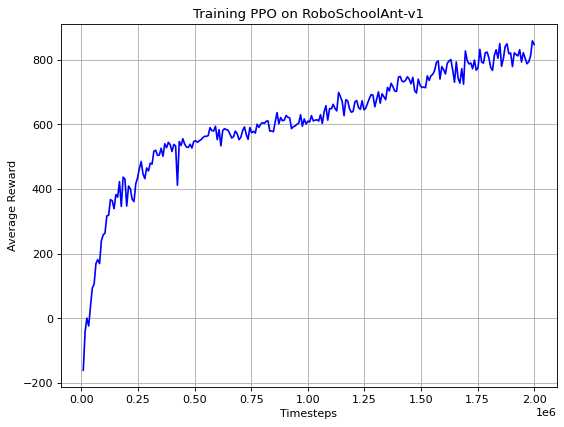

In [14]:
# plot training curve

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timestep_list, ave_reward_list, color="blue")
plt.title("Training PPO on RoboSchoolAnt-v1")
plt.xlabel("Timesteps")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

**Test - get weights**

In [15]:
# get weights 

get_weights_path = '/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_{}.pth'.format(parameter_name)

In [16]:
# load new env if needed
env = gym.make("RoboschoolAnt-v1")

# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device,
                using_TD=useTD)


# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device)

#load into ppo_agent
ppo_agent.load_actor(get_weights_path)

**Test - test many episodes & get avg reward**

In [17]:

# test loop
num_test_episodes = 100
test_print_frequency = 10
reward_total = 0

for episode in range(num_test_episodes):
  state = env.reset()
  reward_episode = 0
  
  for t in range (1, max_episode_steps+1):
    action = ppo_agent.select_action(state)
    state, rewardt, done, _ = env.step(action)
    reward_episode += rewardt

    if done:
        break
  
  # clear buffer    
  ppo_agent.buffer.clear()
  
  if (episode % test_print_frequency ==0 ):
    print('Episode {}/{} \t Reward: {}'.format(episode+1, num_test_episodes, reward_episode))

  reward_total += reward_episode

env.close()
print('Average reward across {} episodes: {}'.format(num_test_episodes, reward_total/num_test_episodes))


Episode 1/100 	 Reward: 693.3158636573714
Episode 11/100 	 Reward: 794.1266824565922
Episode 21/100 	 Reward: 865.723176314868
Episode 31/100 	 Reward: 884.0698270904572
Episode 41/100 	 Reward: 805.9933145214964
Episode 51/100 	 Reward: 636.1962185596062
Episode 61/100 	 Reward: 920.2149823092891
Episode 71/100 	 Reward: 843.2671817347515
Episode 81/100 	 Reward: 807.8041451792028
Episode 91/100 	 Reward: 772.338603149522
Average reward across 100 episodes: 826.3219765454062


**Test - test 1 episode & save into gif (or optional render right here too)**

In [18]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from PIL import Image
import glob

Total reward at time step 1: -0.2831683570737369
Total reward at time step 51: 28.148691780088118
Total reward at time step 101: 81.04793229004137
Total reward at time step 151: 114.30840015628348
Total reward at time step 201: 159.00702869393146
Total reward at time step 251: 198.95425600150057
Total reward at time step 301: 231.43333054817356
Total reward at time step 351: 267.69431160008264
Total reward at time step 401: 305.51196117580724
Total reward at time step 451: 339.7726167898513
Total reward at time step 501: 383.54227780098034
Total reward at time step 551: 437.56353196981826
Total reward at time step 601: 496.8442850202659
Total reward at time step 651: 549.6633072083221
Total reward at time step 701: 597.7464934459325
Total reward at time step 751: 646.2057834395549
Total reward at time step 801: 690.4142435335709
Total reward at time step 851: 738.5720791981319
Total reward at time step 901: 786.3218419990018
Total reward at time step 951: 824.0964348382577
Breaked at t

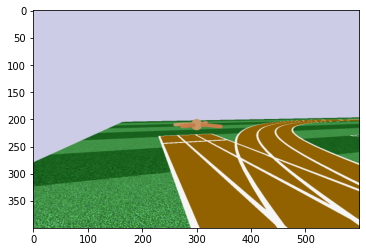

In [22]:
import os.path
from os import path

render_here = False # set to true if you want to see the choppy images on colab

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

state = env.reset()
reward_episode = 0
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

# this is for gif-making 
if path.exists('/content/drive/MyDrive/ECE239AS Group Project/code/gif_ant_segments_{}'.format(parameter_name)) == False:
  os.mkdir('/content/drive/MyDrive/ECE239AS Group Project/code/gif_ant_segments_{}'.format(parameter_name))
save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_ant_segments_{}/'.format(parameter_name)

# play out 1 episode
for i in range(100000):
  action = ppo_agent.select_action(state)
  state, reward, done, info = env.step(action)
  reward_episode += reward
  if i%50 == 0:
    print("Total reward at time step {}: {}".format(i+1, reward_episode))
    screen = env.render(mode='rgb_array')
    # save screen images for gif
    image_i = Image.fromarray(screen)
    image_i.save(save_gif_path + str(i).zfill(4) + '.jpg')
  
  if done:
     break

if render_here:    
  ipythondisplay.clear_output(wait=True)
  display.stop()

env.close()
print("Breaked at time step {}".format(i+1))

In [23]:
# turn saved jpegs into gif 
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_ant_segments_{}/'.format(parameter_name)

fp_in = "/content/drive/MyDrive/ECE239AS Group Project/code/gif_ant_segments_{}/*".format(parameter_name)

fp_out = save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_ant_segments_{}/image.gif'.format(parameter_name)


img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, 
         duration=100, loop=0)

In [21]:
parameter_name

'Steven_ANT_ReLU_5'